In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.svm import SVR


In [2]:
training_data = pd.read_csv("data/train_base.csv")
test_data = pd.read_csv("data/test_base.csv")


In [3]:
training_data.head()


,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0


In [4]:
test_data.head()


,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,31,1398.91,554.42,47.23,521.79,112,0
1,2,49,1410.83,553.52,47.67,521.74,98,0
2,3,126,1418.89,552.59,47.88,520.83,69,0
3,4,106,1406.88,552.64,47.65,521.88,82,0
4,5,98,1419.36,553.29,47.46,521.00,91,0


In [89]:
# Define the target and features
features = ["S1", "S2", "S3", "S4", "Cycle"]
target = "TTF"


In [90]:
X_train = training_data[features]
y_train = training_data[target]

X_test = test_data[features]
y_test = test_data[target]


In [7]:
X_train.head()


,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19


In [8]:
X_test.head()


,S1,S2,S3,S4
0,1398.91,554.42,47.23,521.79
1,1410.83,553.52,47.67,521.74
2,1418.89,552.59,47.88,520.83
3,1406.88,552.64,47.65,521.88
4,1419.36,553.29,47.46,521.00


## Helper Methods

### Hyperparameter tuning

In [9]:
def tune_hyperparameters(regressor, parameters_grid, X_train, y_train, cv=5):

    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
        y_train (series): The training labels
    """
    grid = GridSearchCV(regressor, parameters_grid, cv=cv)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_


### Model fitting and predictions

In [10]:
def train_model_and_predict(regressor, X_train, y_train, X_test):

    """Train and predict a regression model

    Args:
        regressor (str): The model name identifier
        X_train (dataframe): The training features
        y_train (series): The training labels
        X_test (dataframe): The test features
    """
    regressor.fit(X_train, y_train)
    training_predictions = regressor.predict(X_train)
    test_predictions = regressor.predict(X_test)
    return training_predictions, test_predictions


### Calculate regression metrics on training and test data for a single model
Metrics to be considered:
- RMSE
- R2 score

In [11]:
def calculate_regression_metrics(
    model_name, training_actual, training_predictions, test_actual, test_predictions
):
    """Calculate regression metrics on training and test data"""
    # Calculate training metrics
    training_r2 = r2_score(training_actual, training_predictions)
    training_rmse = np.sqrt(mean_squared_error(training_actual, training_predictions))

    # Calculate test metrics
    test_r2 = r2_score(test_actual, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))

    return pd.DataFrame(
        {
            f"{model_name} (Training)": {"R2": training_r2, "RMSE": training_rmse},
            f"{model_name} (Test)": {"R2": test_r2, "RMSE": test_rmse},
        }
    )


### Plot regression coefficients for a single model

In [12]:
def plot_features_weights(model, weights, feature_names, weights_type="c"):

    """Plot regression coefficients weights or feature importance.

    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'

    Returns:
        plot of either regression coefficients weights or feature importance


    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({"Weights": weights}, feature_names)
    W.sort_values(by="Weights", ascending=True).plot(
        kind="barh", color="r", figsize=(px, py)
    )
    label = " Coefficients" if weights_type == "c" else " Features Importance"
    plt.xlabel(model + label)
    plt.gca().legend_ = None


### Plot residuals for a single model

In [13]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):

    """Print the regression residuals.

    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data

    Returns:
        Plot of regression residuals

    """

    plt.scatter(
        y_train_pred,
        y_train_pred - y_train,
        c="blue",
        marker="o",
        label="Training data",
    )
    plt.scatter(
        y_test_pred, y_test_pred - y_test, c="lightgreen", marker="s", label="Test data"
    )
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.hlines(y=0, xmin=-50, xmax=400, color="red", lw=2)
    plt.title(model + " Residuals")
    plt.show()


## Linear Regression

In [14]:
# Linear regression
linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    linear_regressor, X_train, y_train, X_test
)


In [15]:
# Calculate metrics
linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression", y_train, training_predictions, y_test, test_predictions
)
linear_regression_metrics


,Linear Regression (Training),Linear Regression (Test)
R2,0.530703,0.277052
RMSE,47.185977,35.333226


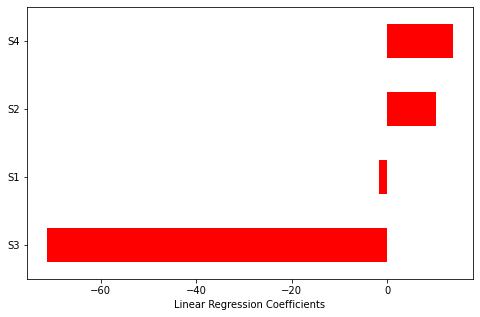

In [16]:
plot_features_weights("Linear Regression", linear_regressor.coef_, features, "c")


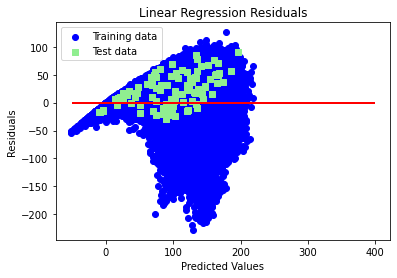

In [17]:
plot_residual(
    "Linear Regression",
    training_data[target],
    training_predictions,
    test_data[target],
    test_predictions,
)


### Lasso Regression

In [24]:
# Define hyperparameter space and identify the best hyperparameters
grid_space = np.linspace(0.00001, 1, 10)
parameters_grid = {"alpha": grid_space}
tuned_lasso_regressor = tune_hyperparameters(Lasso(), parameters_grid, X_train, y_train)


The best parameters are {'alpha': 1e-05} with a score of 0.5171158857635609


In [26]:
# Make predictions on training and test data
training_predictions = tuned_lasso_regressor.predict(X_train)
test_predictions = tuned_lasso_regressor.predict(X_test)


In [27]:
# Calculate metrics
lasso_regression_metrics = calculate_regression_metrics(
    "Lasso Regression", y_train, training_predictions, y_test, test_predictions
)
lasso_regression_metrics


,Lasso Regression (Training),Lasso Regression (Test)
R2,0.530703,0.277052
RMSE,47.185977,35.333227


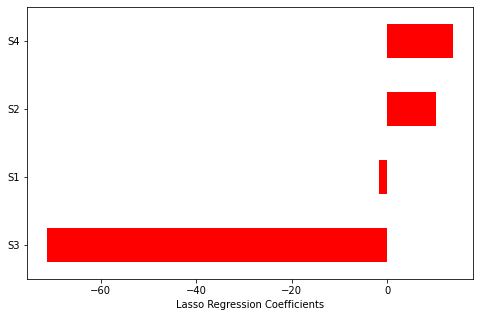

In [28]:
plot_features_weights("Lasso Regression", tuned_lasso_regressor.coef_, features, "c")


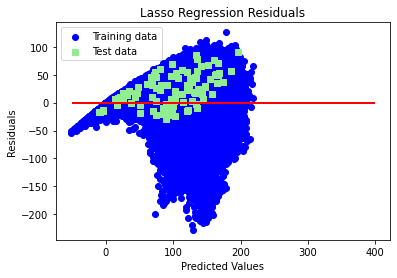

In [30]:
plot_residual(
    "Lasso Regression", y_train, training_predictions, y_test, test_predictions
)


### Ridge Regression

In [31]:
# Perform grid search for Ridge regression
alpha_space = [0.001, 0.01, 0.1, 1, 10]
parameters_grid = {"alpha": alpha_space}
tuned_ridge_regressor = tune_hyperparameters(Ridge(), parameters_grid, X_train, y_train)


The best parameters are {'alpha': 10} with a score of 0.5171209171741322


In [33]:
# Make predictions on training and test data
training_predictions = tuned_ridge_regressor.predict(X_train)
test_predictions = tuned_ridge_regressor.predict(X_test)


In [34]:
# Calculate metrics
ridge_regression_metrics = calculate_regression_metrics(
    "Ridge Regression", y_train, training_predictions, y_test, test_predictions
)
ridge_regression_metrics


,Ridge Regression (Training),Ridge Regression (Test)
R2,0.530687,0.276352
RMSE,47.186737,35.350329


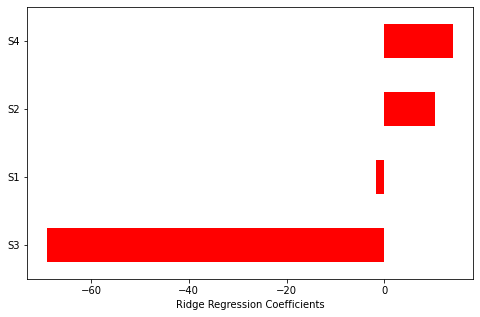

In [35]:
# Plot features weights
plot_features_weights("Ridge Regression", tuned_ridge_regressor.coef_, features, "c")


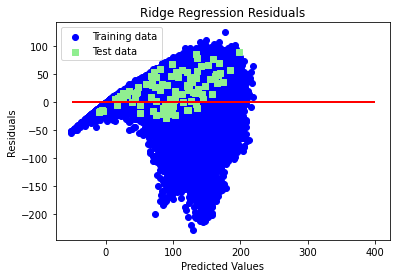

In [36]:
# Plot residuals
plot_residual(
    "Ridge Regression", y_train, training_predictions, y_test, test_predictions
)


## Elastic Net Regression

In [37]:
# Perform grid search for Elastic Net regression
alpha_space = [0.001, 0.05, 0.1]
l1_ratio_space = [0.5, 0.6, 0.9]
parameters_grid = {"alpha": alpha_space, "l1_ratio": l1_ratio_space}
tuned_elastic_net_regressor = tune_hyperparameters(
    ElasticNet(), parameters_grid, X_train, y_train
)


The best parameters are {'alpha': 0.001, 'l1_ratio': 0.6} with a score of 0.5171247818488915


In [38]:
# Make predictions on training and test data
training_predictions = tuned_elastic_net_regressor.predict(X_train)
test_predictions = tuned_elastic_net_regressor.predict(X_test)


In [39]:
# Calculate metrics
elastic_net_regression_metrics = calculate_regression_metrics(
    "Elastic Net Regression", y_train, training_predictions, y_test, test_predictions
)
elastic_net_regression_metrics


,Elastic Net Regression (Training),Elastic Net Regression (Test)
R2,0.530692,0.276469
RMSE,47.186516,35.347480


## Polynomial Regression

In [40]:
# Perform search for best degree of polynomial regression
degree_space = [2, 3, 4, 5]
best_score = 0
best_degree = 0

for degree in degree_space:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(training_data[features])
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, training_data[target])
    scores = cross_val_score(
        polynomial_regressor, X_train_poly, training_data[target], cv=5
    )  # Change k-fold cv value here
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_degree = degree


In [41]:
best_degree


5

In [46]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=5)
X_train_poly = poly_features.fit_transform(training_data[features])
X_test_poly = poly_features.fit_transform(test_data[features])


In [47]:
# Fit polynomial regression model and make predictions
polynomial_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    polynomial_regressor, X_train_poly, training_data[target], X_test_poly
)


In [49]:
# Calculate metrics
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_train, training_predictions, y_test, test_predictions
)
polynomial_regression_metrics


,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.543588,0.278474
RMSE,46.533656,35.298458


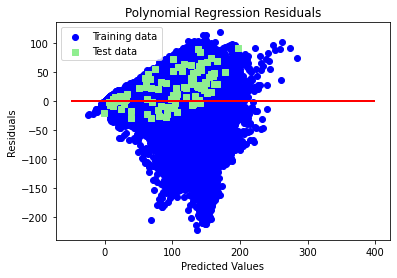

In [51]:
plot_residual(
    "Polynomial Regression", y_train, training_predictions, y_test, test_predictions
)


## Decision Tree Regression

In [53]:
# Perform grid search for Decision Tree regression
parameters_grid = {"max_depth": [4, 5, 6, 7, 8, 9]}
decision_tree_regressor = tune_hyperparameters(
    DecisionTreeRegressor(), parameters_grid, X_train, y_train
)


The best parameters are {'max_depth': 6} with a score of 0.5006656819431712


In [54]:
# Make predictions on training and test data
training_predictions = decision_tree_regressor.predict(X_train)
test_predictions = decision_tree_regressor.predict(X_test)


In [55]:
# Calculate metrics
decision_tree_regression_metrics = calculate_regression_metrics(
    "Decision Tree Regression", y_train, training_predictions, y_test, test_predictions
)
decision_tree_regression_metrics


,Decision Tree Regression (Training),Decision Tree Regression (Test)
R2,0.545733,0.233683
RMSE,46.424204,36.377606


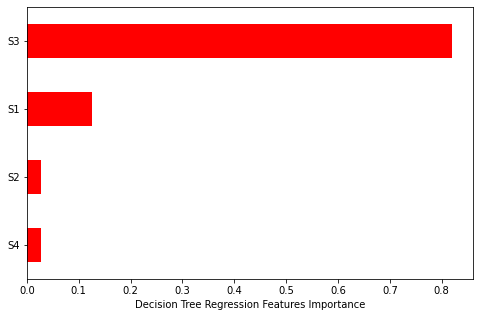

In [58]:
# Plot features weights
plot_features_weights(
    "Decision Tree Regression",
    decision_tree_regressor.feature_importances_,
    features,
    "t",
)


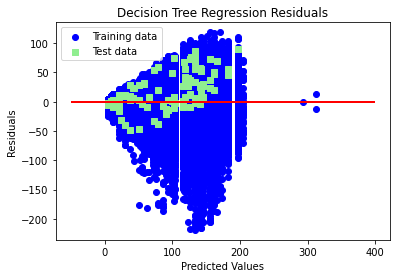

In [57]:
# Plot residuals
plot_residual(
    "Decision Tree Regression", y_train, training_predictions, y_test, test_predictions
)


## Random Forest Regression

In [63]:
# Perform grid search for Random Forest regression
estimators_space = [60, 70, 80, 90, 100]
features_space = [2, 3, 4, 5]
depth_space = [4, 5, 6, 7, 8, 9]

parameters_grid = {
    "n_estimators": estimators_space,
    "max_features": features_space,
    "max_depth": depth_space,
}
random_forest_regressor = tune_hyperparameters(
    RandomForestRegressor(), parameters_grid, X_train, y_train
)


/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:379: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 688, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 441, in fit
    trees = Parallel(
  File "/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-p

The best parameters are {'max_depth': 6, 'max_features': 2, 'n_estimators': 100} with a score of 0.520072504508669


In [69]:
# Test random forest model
random_forest_regressor = RandomForestRegressor(
    n_estimators=100, max_features=3, max_depth=4
)
random_forest_regressor.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, max_features=3)

In [70]:
# Make predictions on training and test data
training_predictions = random_forest_regressor.predict(X_train)
test_predictions = random_forest_regressor.predict(X_test)


In [65]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.555365,0.302544
RMSE,45.929375,34.704698


In [71]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.539903,0.310415
RMSE,46.721170,34.508307


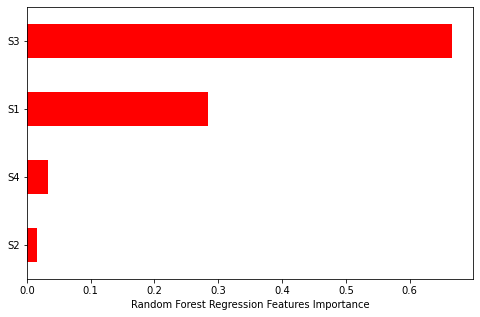

In [72]:
# Plot features weights
plot_features_weights(
    "Random Forest Regression",
    random_forest_regressor.feature_importances_,
    features,
    "t",
)


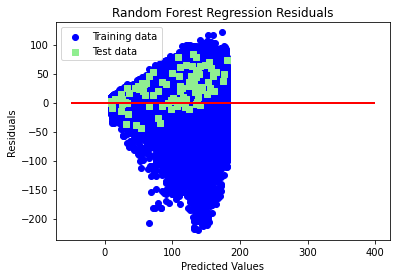

In [73]:
# Plot residuals
plot_residual(
    "Random Forest Regression", y_train, training_predictions, y_test, test_predictions
)


### Support Vector Regression

In [91]:
# Define SVR model
svr_regressor = SVR(kernel="linear")

# Fit SVR model and make predictions
training_predictions, test_predictions = train_model_and_predict(
    svr_regressor, X_train, y_train, X_test
)


In [92]:
# Calculate metrics
svr_regression_metrics = calculate_regression_metrics(
    "SVR Regression", y_train, training_predictions, y_test, test_predictions
)
svr_regression_metrics


,SVR Regression (Training),SVR Regression (Test)
R2,0.635436,0.499981
RMSE,41.588764,29.384824


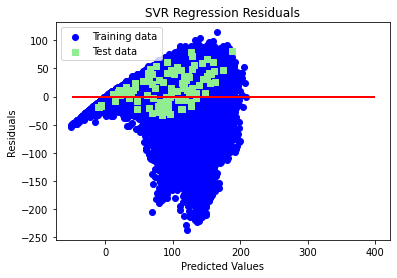

In [88]:
# Plot residuals
plot_residual("SVR Regression", y_train, training_predictions, y_test, test_predictions)


## Comparison of Regression Algorithms

In [93]:
metrics = pd.concat(
    [
        linear_regression_metrics,
        ridge_regression_metrics,
        lasso_regression_metrics,
        elastic_net_regression_metrics,
        polynomial_regression_metrics,
        decision_tree_regression_metrics,
        random_forest_regression_metrics,
        svr_regression_metrics,
    ],
    axis=1,
)
testing_metrics = metrics.filter(like="(Test)", axis=1)
testing_metrics


,Linear Regression (Test),Ridge Regression (Test),Lasso Regression (Test),Elastic Net Regression (Test),Polynomial Regression (Test),Decision Tree Regression (Test),Random Forest Regression (Test),SVR Regression (Test)
R2,0.277052,0.276352,0.277052,0.276469,0.278474,0.233683,0.310415,0.499981
RMSE,35.333226,35.350329,35.333227,35.347480,35.298458,36.377606,34.508307,29.384824
